# *Traffic Sign Recognizer - 99% accuracy*

## Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import torch
# from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

## Assigning Path for Dataset

In [2]:
data_dir = './data'
train_path = './data/Train'
test_path = './data/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Finding Total Classes

In [3]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [4]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Visualizing The Dataset

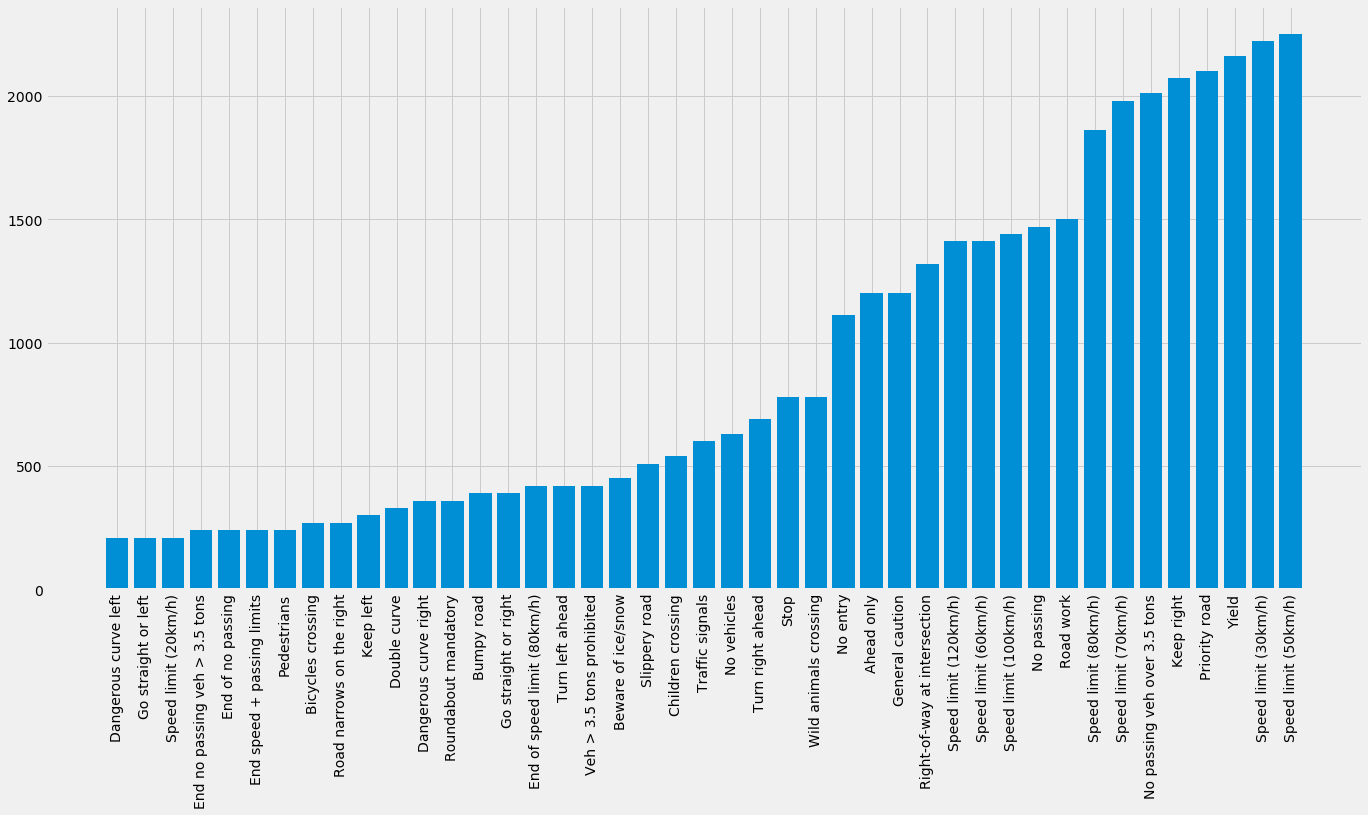

In [5]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

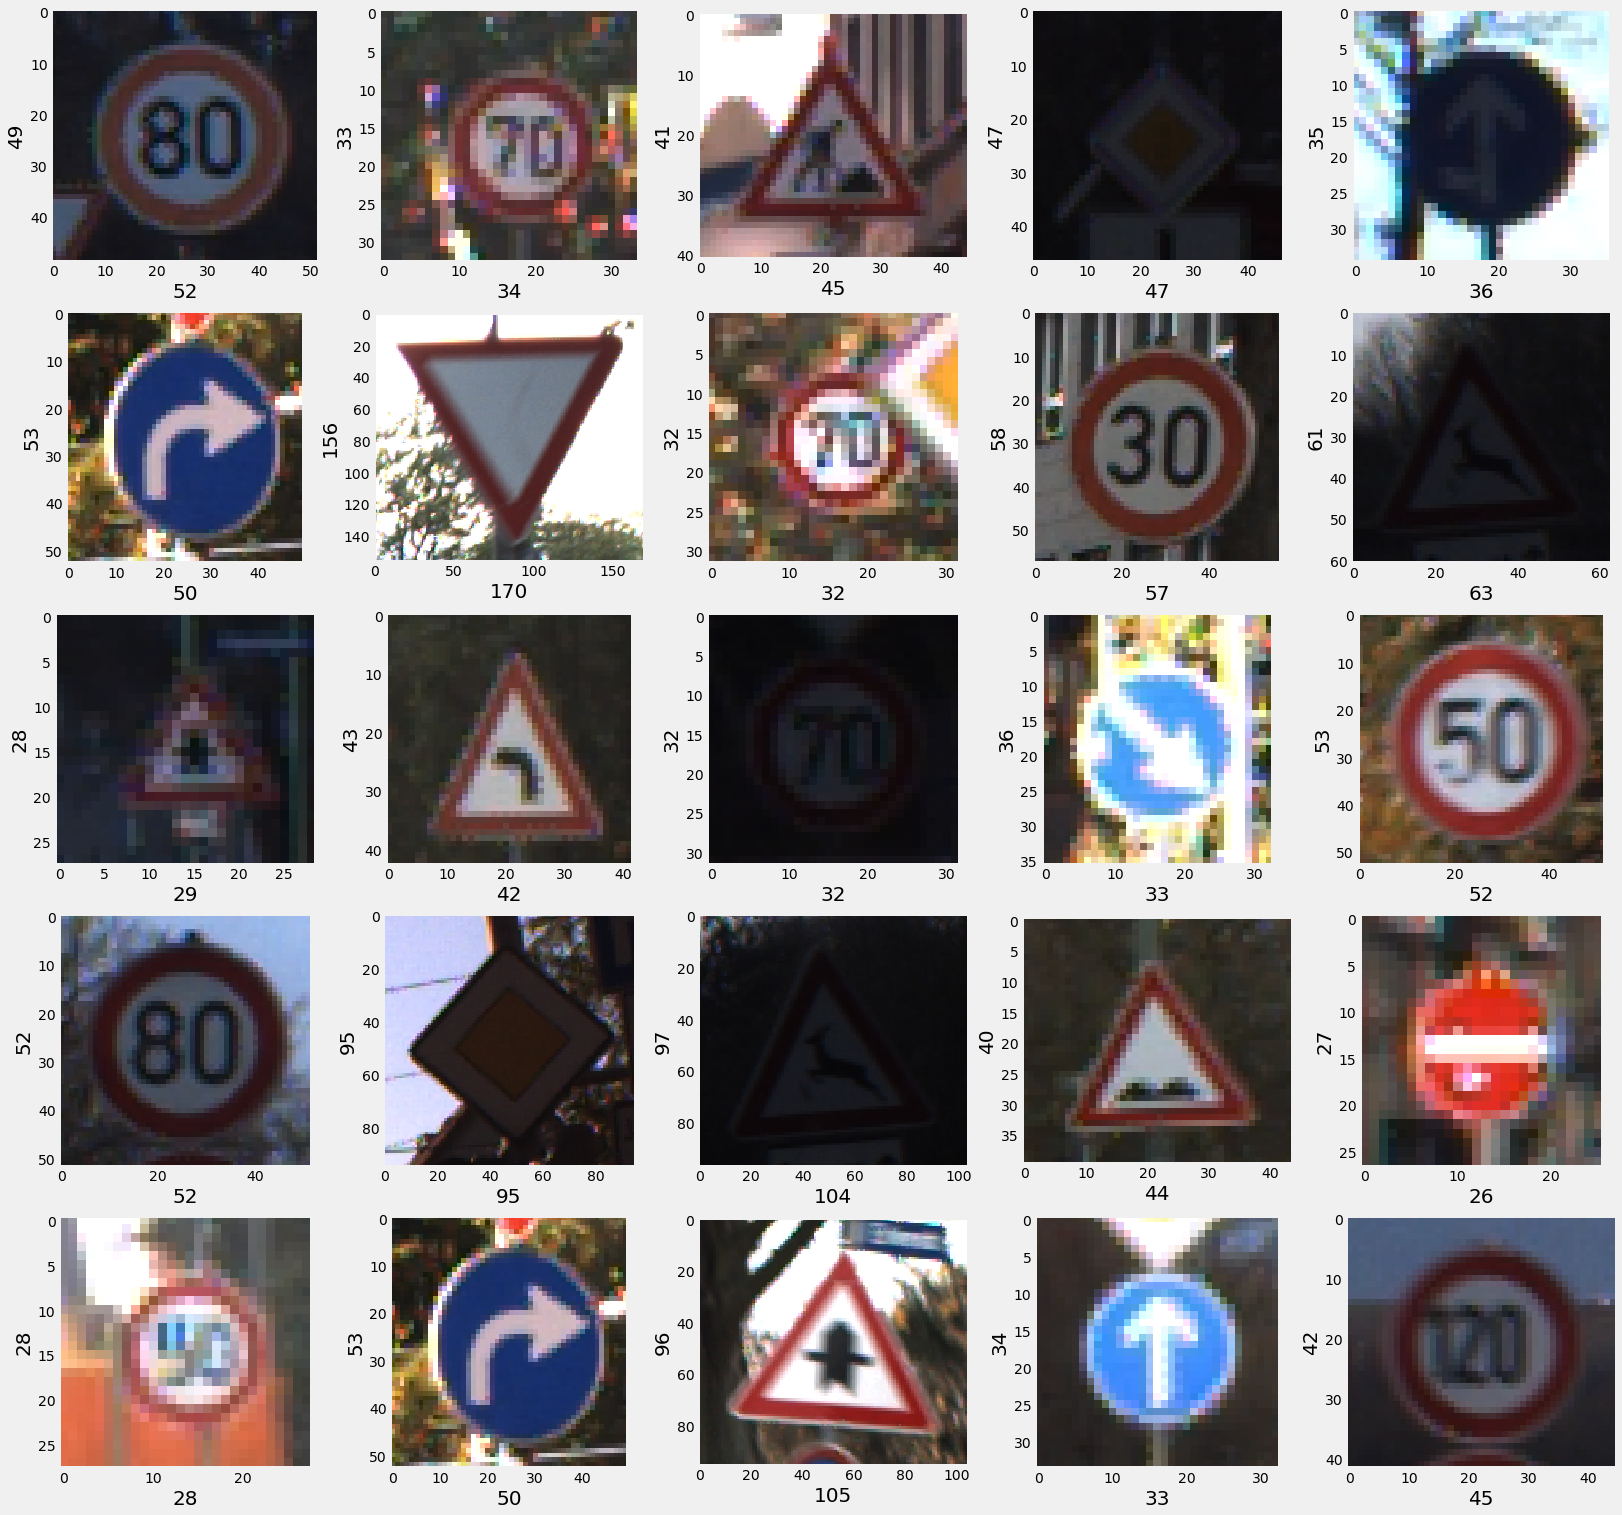

In [6]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Collecting the Training Data

In [7]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffling the training data

In [8]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [9]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## One hot encoding the labels

In [10]:
train_shape = y_train.shape
val_shape = y_val.shape
y_train = torch.tensor(y_train).unsqueeze_(1)
y_train = torch.zeros(train_shape[0], NUM_CATEGORIES).scatter_(1, y_train, 1)
y_val = torch.tensor(y_val).unsqueeze_(1)
y_val = torch.zeros(val_shape[0], NUM_CATEGORIES).scatter_(1, y_val, 1)

X_train = torch.tensor(X_train).permute(0,3,1,2)
X_val = torch.tensor(X_val).permute(0,3,1,2)

print(y_train.shape)
print(y_val.shape)
print(X_train.shape)


torch.Size([27446, 43])
torch.Size([11763, 43])
torch.Size([27446, 3, 30, 30])


## Making the model

In [11]:
from models.model import Model
model = Model(NUM_CATEGORIES).cuda()


In [12]:
lr = 0.004
epochs = 30

optimizer = torch.optim.Adam(
    model.parameters(), lr=lr, weight_decay=lr/(epochs*0.5))
#  Adam(lr=lr, decay=lr / (epochs * 0.5))
criterion = torch.nn.CrossEntropyLoss().cuda()
lr_decayer = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', factor=0.5, patience=2, verbose=True)
val_loss = float('Inf')


## Augmenting the data and training the model

In [13]:
from models.data_loader import MyDataLoader
train_folder = MyDataLoader(X_train, y_train)
valid_folder = MyDataLoader(X_val, y_val)

train_loader = torch.utils.data.DataLoader(
    train_folder,
    batch_size=32, shuffle=True,
    num_workers=16, pin_memory=True,
    drop_last=True
)

val_loader = torch.utils.data.DataLoader(
    valid_folder,
    batch_size=32, shuffle=False,
    num_workers=16, pin_memory=True,
    drop_last=False
)

model.double()

for epoch in range(epochs):

    losses = 0.
    precs = 0.

    model.train()

    for i, (input, target) in enumerate(train_loader):
        input = input.cuda()

        target = target.cuda()
        model.zero_grad()

        output = model(input)

        loss = criterion(output, target)

        prec = torch.sum(torch.argmax(output.detach().cpu(), dim=1)
                         == torch.argmax(target.detach().cpu(), dim=1))
        precs = (precs*i+prec.item())/(i+1)
        losses = (losses*i+loss.item())/(i+1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print('Epoch:[{0}][{1}/{2}]\t''Loss{loss:.3f}\t''Prec{prec:.3f}(avg:{precs:.3f})'.format(epoch, i, len(train_loader), loss=losses, prec=prec, precs=precs)
                  )

    losses = 0
    precs=0

    model.eval()

    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda()

            target = target.cuda()

            output = model(input)

            loss = criterion(output, target)

            prec = torch.sum(torch.argmax(output.detach().cpu(), dim=1)
                             == torch.argmax(target.detach().cpu(), dim=1))
            precs = (precs*i+prec.item())/(i+1)
            losses = (losses*i+loss.item())/(i+1)

            if i % 10 == 0:
                print('Test:[{0}/{1}]\t''Loss{loss:.3f}\t''Prec{prec:.3f}(avg:{precs:.3f})'.format(i, len(val_loader), loss=losses, prec=prec, precs=precs)
                      )
    lr_decayer.step(losses, epoch)


/home/qyqc/miniconda3/envs/python38/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch:[0][0/857]	Loss3.764	Prec0.000(avg:0.000)
Epoch:[0][10/857]	Loss3.705	Prec6.000(avg:4.182)
Epoch:[0][20/857]	Loss3.656	Prec8.000(avg:5.429)
Epoch:[0][30/857]	Loss3.630	Prec14.000(avg:5.968)
Epoch:[0][40/857]	Loss3.592	Prec11.000(avg:7.195)
Epoch:[0][50/857]	Loss3.564	Prec10.000(avg:8.059)
Epoch:[0][60/857]	Loss3.536	Prec16.000(avg:8.967)
Epoch:[0][70/857]	Loss3.511	Prec15.000(avg:9.746)
Epoch:[0][80/857]	Loss3.502	Prec11.000(avg:10.012)
Epoch:[0][90/857]	Loss3.490	Prec15.000(avg:10.385)
Epoch:[0][100/857]	Loss3.474	Prec18.000(avg:10.842)
Epoch:[0][110/857]	Loss3.461	Prec16.000(avg:11.243)
Epoch:[0][120/857]	Loss3.448	Prec17.000(avg:11.678)
Epoch:[0][130/857]	Loss3.434	Prec14.000(avg:12.122)
Epoch:[0][140/857]	Loss3.425	Prec13.000(avg:12.440)
Epoch:[0][150/857]	Loss3.413	Prec14.000(avg:12.841)
Epoch:[0][160/857]	Loss3.403	Prec17.000(avg:13.168)
Epoch:[0][170/857]	Loss3.391	Prec21.000(avg:13.526)
Epoch:[0][180/857]	Loss3.382	Prec17.000(avg:13.834)
Epoch:[0][190/857]	Loss3.369	Prec1

/home/qyqc/miniconda3/envs/python38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:920: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch:[1][0/857]	Loss3.020	Prec25.000(avg:25.000)
Epoch:[1][10/857]	Loss3.032	Prec25.000(avg:24.636)
Epoch:[1][20/857]	Loss3.012	Prec25.000(avg:25.476)
Epoch:[1][30/857]	Loss3.016	Prec23.000(avg:25.258)
Epoch:[1][40/857]	Loss3.004	Prec26.000(avg:25.610)
Epoch:[1][50/857]	Loss2.998	Prec23.000(avg:25.824)
Epoch:[1][60/857]	Loss2.994	Prec24.000(avg:25.967)
Epoch:[1][70/857]	Loss2.993	Prec29.000(avg:26.014)
Epoch:[1][80/857]	Loss2.998	Prec26.000(avg:25.852)
Epoch:[1][90/857]	Loss2.998	Prec24.000(avg:25.879)
Epoch:[1][100/857]	Loss2.997	Prec22.000(avg:25.941)
Epoch:[1][110/857]	Loss2.996	Prec26.000(avg:25.937)
Epoch:[1][120/857]	Loss2.996	Prec27.000(avg:25.950)
Epoch:[1][130/857]	Loss2.995	Prec27.000(avg:25.985)
Epoch:[1][140/857]	Loss2.996	Prec24.000(avg:25.979)
Epoch:[1][150/857]	Loss2.995	Prec27.000(avg:26.007)
Epoch:[1][160/857]	Loss2.996	Prec26.000(avg:25.988)
Epoch:[1][170/857]	Loss2.996	Prec26.000(avg:25.988)
Epoch:[1][180/857]	Loss2.998	Prec26.000(avg:25.917)
Epoch:[1][190/857]	Loss

## Evaluating the model

In [14]:
torch.save({'model':model.state_dict()},'model.pth.tar')

In [16]:
import torchattacks

atk = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=4)
atk_images = atk(X_val,y_val)


RuntimeError: CUDA out of memory. Tried to allocate 696.00 MiB (GPU 0; 6.00 GiB total capacity; 4.93 GiB already allocated; 0 bytes free; 4.96 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Loading the test data and running the predictions

In [ ]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = model.predict_classes(X_test)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

## Visualizing the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

## Classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

## Predictions on Test Data

In [ ]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()